# Classificação de dígitos escritos a mão (MNIST Dataset)

Neste exemplo, nosso objetivo será classificar imagens de dígitos escritos a mão automaticamente. O dataset que estaremos utilizando neste tutorial é chamado de dataset MNIST, o qual é muito utilizado para exemplificar o uso de modelos de aprendizado de máquina em imagens. Este dataset é composto de imagens de dígitos manuscritos.

<!-- Baseado no trabalho de [Aurélien Geron](https://github.com/ageron/handson-ml). -->

## Setup

Primeiro, vamos importar as bibliotecas necessárias que serão utilizadas. Vale a pena destacar algumas bibliotecas aqui. [Pandas](https://pandas.pydata.org/) é uma das bibliotecas mais utilizadas para manipulação e análise de dados. Normalmente, utilizada com [Numpy](https://numpy.org/) que serve para manipulação de _arrays_ e matrizes multidimensionais, possuindo uma larga coleção de funções matemáticas para trabalhar com estas estruturas. [Seaborn](https://seaborn.pydata.org/) é uma bilioteca para criar gráficos baseada no [matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.html) que vimos anteriormente.

Além destas, temos a [sklearn](https://scikit-learn.org/stable/). Esta é uma biblioteca de aprendizado de máquina de código aberto que contém diversos algoritmos prontos para utilizarmos, desde uma simples regressão linear até redes neurais artificiais complexas. Vermos mais a frente detalhes de suas funcionalidades.

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import cluster
from sklearn import datasets
from sklearn import metrics
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

A seguir, vamos definir uma função que gera uma matriz de confusão ...

In [0]:
def plot_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

# MNINST

## Carregando o dataset MNIST

Primeiro vamos carregar o dataset atráves da própria biblioteca [sklearn](https://scikit-learn.org/stable/)

In [6]:
digits = datasets.load_digits()
digits.keys()

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])

Em `digits` temos os seguintes componentes
  - `data`: Um `array` bidimensional com 1797 registros que representam as os pixels de cada em imagem. São 64 pixels pois as imagens são de tamanho 8x8. Estes registros seram utilizados mais adiante para treinar e testar o nosso modelo. Cada coluna aqui (64 colunas) são chamadas de _features_.
  - `target`: O target representa o número que cada imagem representa, exemplo, `[[0, 1, 2, ..., 8, 9, 8]]`
  - `target_names`: Este contém todas as possíveis classes que queremos prever, ou seja, `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`
  - `images`: Aqui temos todas as imagens para poder apresenta-las visualmente
  - `DESC`: E por último, temos a descrição do _dataset_

Quando importamos um _dataset_ a partir do [sklearn](https://scikit-learn.org/stable/), normalmente teremos componentes similares a este. Os dados para treinamento/predição, o _target_ (o resultado que esperamos prever) e uma descrição do _dataset_ importado. A seguir vamos inspecionar estes componentes

In [15]:
pd.DataFrame(digits.data).astype('int64')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
0,0,0,5,13,9,1,0,0,0,0,13,15,10,15,5,0,0,3,15,2,0,11,8,0,0,4,12,0,0,8,8,0,0,5,8,0,0,9,8,0,0,4,11,0,1,12,7,0,0,2,14,5,10,12,0,0,0,0,6,13,10,0,0,0
1,0,0,0,12,13,5,0,0,0,0,0,11,16,9,0,0,0,0,3,15,16,6,0,0,0,7,15,16,16,2,0,0,0,0,1,16,16,3,0,0,0,0,1,16,16,6,0,0,0,0,1,16,16,6,0,0,0,0,0,11,16,10,0,0
2,0,0,0,4,15,12,0,0,0,0,3,16,15,14,0,0,0,0,8,13,8,16,0,0,0,0,1,6,15,11,0,0,0,1,8,13,15,1,0,0,0,9,16,16,5,0,0,0,0,3,13,16,16,11,5,0,0,0,0,3,11,16,9,0
3,0,0,7,15,13,1,0,0,0,8,13,6,15,4,0,0,0,2,1,13,13,0,0,0,0,0,2,15,11,1,0,0,0,0,0,1,12,12,1,0,0,0,0,0,1,10,8,0,0,0,8,4,5,14,9,0,0,0,7,13,13,9,0,0
4,0,0,0,1,11,0,0,0,0,0,0,7,8,0,0,0,0,0,1,13,6,2,2,0,0,0,7,15,0,9,8,0,0,5,16,10,0,16,6,0,0,4,15,16,13,16,1,0,0,0,0,3,15,10,0,0,0,0,0,2,16,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1792,0,0,4,10,13,6,0,0,0,1,16,14,12,16,3,0,0,4,16,6,3,16,4,0,0,0,12,16,16,16,5,0,0,0,0,4,4,16,8,0,0,0,0,0,0,15,5,0,0,0,5,7,7,16,4,0,0,0,2,14,15,9,0,0
1793,0,0,6,16,13,11,1,0,0,0,16,15,12,16,1,0,0,3,16,7,0,13,6,0,0,4,16,0,0,10,8,0,0,8,16,0,0,14,6,0,0,5,16,7,9,16,5,0,0,1,15,16,16,16,1,0,0,0,6,16,14,6,0,0
1794,0,0,1,11,15,1,0,0,0,0,13,16,8,2,1,0,0,0,16,15,10,16,5,0,0,0,8,16,16,7,0,0,0,0,9,16,16,4,0,0,0,0,16,14,16,15,0,0,0,0,15,15,15,16,0,0,0,0,2,9,13,6,0,0
1795,0,0,2,10,7,0,0,0,0,0,14,16,16,15,1,0,0,4,16,7,3,16,7,0,0,5,16,10,7,16,4,0,0,0,5,14,14,16,4,0,0,0,0,0,0,16,2,0,0,0,4,7,7,16,2,0,0,0,5,12,16,12,0,0


In [19]:
pd.DataFrame(digits.target).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1757,1758,1759,1760,1761,1762,1763,1764,1765,1766,1767,1768,1769,1770,1771,1772,1773,1774,1775,1776,1777,1778,1779,1780,1781,1782,1783,1784,1785,1786,1787,1788,1789,1790,1791,1792,1793,1794,1795,1796
0,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,9,5,5,6,5,0,9,8,9,...,1,3,9,1,7,6,8,4,3,1,4,0,5,3,6,9,6,1,7,5,4,4,7,2,8,2,2,5,7,9,5,4,8,8,4,9,0,8,9,8


In [21]:
print(digits.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

A seguir, vamos isolar cada componente 

In [0]:
digits_data = digits.data
digits_target = digits.target
digits_images = digits.images

Caso não tivessemos disponíveis uma variável com as classes que queremos prever, poderíamos consegui-las da seguinte maneira 

In [0]:
number_digits = len(np.unique(digits.target))

Como temos podemos podemos atribuir diretamente

In [0]:
number_digits = digits.target_names

Existe uma função chamada `shape` muito útil para inspecionarmos a dimensionalidade dos objetos que estamos trabalhando

In [28]:
print(f"digits_data = {digits_data.shape}")
print(f"digits_target = {digits_target.shape}")
print(f"digits_images = {digits_images.shape}")
print(f"number_digits = {number_digits.shape}")

digits_data = (1797, 64)
digits_target = (1797,)
digits_images = (1797, 8, 8)
number_digits = (10,)


Para exemplificar, a seguir vamos mostrar as primeiras 64 imagens (`digits_images`) com seu respectivo rótulo (_target_)

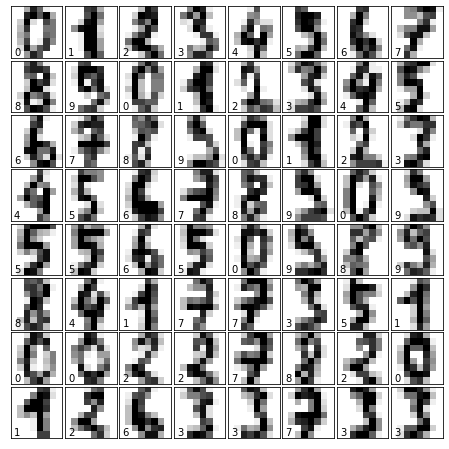

In [31]:
# Tamanho da figura (largura, altura) em polegadas
fig = plt.figure(figsize=(6, 6))

# Ajustando os subplots (cada imagem na figura)
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# Então, iteramos as primeiras 64 imagens
for i in range(64):
    # Inicializando os subplots: adiciona um subplot na posição i+1
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    # Mostra a imagem de posição i
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    # rotula a imagem com seu respectivo rótulo
    ax.text(0, 7, str(digits.target[i]))

# mostra a figura
plt.show()

## Explorando o Dataset

### PCA (Principal Component Analysis)

Como o conjunto de dados de dígitos contém 64 features (no nosso caso, os pixels), visualizar a relação entre os dígitos pode ser uma tarefa desafiadora. Você pode imaginar que é muito difícil entender a estrutura e manter a visão geral dos dados dos dígitos. Nesses casos, é dito que você está trabalhando com um conjunto de dados de alta dimensão.

A alta dimensionalidade dos dados é um resultado direto da tentativa de descrever os objetos por meio de um conjunto de features. Outros exemplos de dados de alta dimensão são, por exemplo, dados financeiros, dados climáticos, neuroimagem.

Dado a complexidade, vamos usar uma técnica chamada análise de componentes principais (PCA) para visualiazar os dados. A ideia no PCA é encontrar uma combinação linear das variáveis que contém a maior parte das informações. Uma nova variável chamada de “componente principal” pode substituir duas variáveis originais.

[Para saber mais sobre PCA](https://www.lauradhamilton.com/introduction-to-principal-component-analysis-pca).

Vocês podem perceber que quando utilizamos técnicas/modelos do [sklearn](https://scikit-learn.org/stable/), normalmente estes contém as mesmas funções para sua aplicação (criação do objeto, `fit` e `transform`/`predict`) e esperam a mesma estrutura/entrada (parâmetros de configuração, dados multidimensionais e amostras) respectivamente.

A seguir vamos criar o objeto passando os parâmetros que são específicos da técnica/modelo

In [0]:
pca = PCA(n_components=2)

Neste caso, especificamos que queremos gerar os dois primeiros componentes principais, que são os que mais explicam os dados.

A seguir devemos utilizar a função `fit` nos dados que queremos aplicar a técnica/modelo. Esta função basicamente ajusta a técnica/modelo aos dados espeficados retornando os parâmetros especificados. Podem perceber que alguns parâmetros não foram especificados, assim a técnica utilizou os padrões de cada parâmetro

In [36]:
pca.fit(digits_data)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

 Se utilizarmos a função `pca.explained_variance_ratio_` podemos ver a porcentagem se explicação dos dados reduzidos em relação aos dados originais

In [37]:
pca.explained_variance_ratio_

array([0.14890594, 0.13618771])

Somando as porcentagens do primeiro e segundo componente principal vemos que a explicabilidade pe apenas de ~28%. Poderíamos passar como parâmetro a porcentagem de explicabilidade como parâmtro também

In [42]:
pca_95 = PCA(0.95).fit(digits_data)
print(pca_95.explained_variance_ratio_)
pca_95.explained_variance_ratio_.shape

[0.14890594 0.13618771 0.11794594 0.08409979 0.05782415 0.0491691
 0.04315987 0.03661373 0.03353248 0.03078806 0.02372341 0.02272697
 0.01821863 0.01773855 0.01467101 0.01409716 0.01318589 0.01248138
 0.01017718 0.00905617 0.00889538 0.00797123 0.00767493 0.00722904
 0.00695889 0.00596081 0.00575615 0.00515158 0.0048954 ]


(29,)

Contudo, podemos ver que assim retornou 29 componentes, o que pode ser considerado uma alta dimensionalidade em alguns casos. Para poder visualizar a distribuição das amostras (registros ou imagens) mais a frente iremos continuar nossa análise apenas com 2 componentes principais

Finalmente vamos utilizar a função `transform` para obter os dados reduzidos efetivamente

In [0]:
reduced_data_pca = pca.transform(digits_data)

Poderiámos também fazer o processo completo (criar, ajustar e transformar) em uma linha utilizando uma função 

In [45]:
reduced_data_pca = PCA(n_components=2).fit_transform(digits_data)
print(reduced_data_pca)
reduced_data_pca.shape

[[ -1.25946416  21.27488265]
 [  7.95760658 -20.76870039]
 [  6.99192323  -9.95598487]
 ...
 [ 10.80128735  -6.9602536 ]
 [ -4.8721005   12.42395203]
 [ -0.34438308   6.3655498 ]]


(1797, 2)

Como agora temos apenas duas dimensões ao invés de 64 podemos visualizar a distribuição dos dados em um gráfico 2D, chamado de gráfico de dispersão (`scatter_plot`)

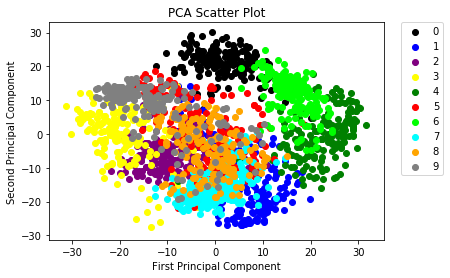

In [50]:
colors = ['black', 'blue', 'purple', 'yellow', 'green', 'red', 'lime', 'cyan', 'orange', 'gray']
for i in range(len(colors)):
    x = reduced_data_pca[:, 0][digits.target == i]
    y = reduced_data_pca[:, 1][digits.target == i]
    plt.scatter(x, y, c=colors[i])
plt.legend(digits.target_names, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title("PCA Scatter Plot")
plt.show()

## Normalização dos dados

Vamos pré-processar os dados. Você pode padronizar os dados de dígitos usando, por exemplo, o método [scale](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html) do [sklearn.preprocessing](https://scikit-learn.org/stable/modules/preprocessing.html).

Ao padronizar os dados, você desloca a distribuição de cada atributo para ter uma média de zero e um desvio padrão de um (variação de unidade).

O objetivo da normalização é alterar os valores das colunas numéricas no conjunto de dados para uma escala comum, sem distorcer as diferenças nos intervalos de valores. Para o aprendizado de máquina, nem todos os conjuntos de dados requerem normalização. Esse método é necessário apenas quando os parâmetros tiverem intervalos muito diferentes.

In [0]:
data = scale(digits.data)

## Split data

Para aplicação de um modelo precisamos separar o conjunto de dados em treinamento e teste. Isto, é necessário pois se treinarmos o modelo em cima de todo o conjunto de dados podemos criar um problema chamado [overfitting](https://pt.wikipedia.org/wiki/Sobreajuste) (sobreajuste). Onde o modelo fica muito especializado nos dados tendo uma alta acurácia somente nos dados utilizados no treino e quando amostras (no nosso caso uma nova imagem) novas são utilizadas para predição o modelo tem uma baixa acurácia. Além do mais, não teremos como avaliar nosso modelo com um conjunto de dados que nunca foi 'visto' sem os dados de teste. O ideal é alcançar um equilíbrio entre a acurácia do treinamento e do teste. 

A seguir, iremos utilizar a função [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) do [sklearn.model_selection](https://scikit-learn.org/stable/model_selection.html). Esta função faz o trabalho para nós de separar os dados de maneira aleátoria, sem enviesar a escolha dos dados ao nosso critério. Para garantir a reprodutibilidade do experimento neste caso estamos passando um parâmetro chamado `random_state`, ou seja, cada vez que rodarmos a função ela irá nos retornar o mesmo conjunto de dados.

In [0]:
X_train, X_test, y_train, y_test, images_train, images_test = train_test_split(data, digits.target, digits.images, test_size=0.25, random_state=42)

Como vocês podem ver, estamos passando os dados completos e recebendo eles separados. Precisamos também dos rótulos (resposta) respectivos de cada conjunto de dados que forma separados. Normalmente, nomeamos os dados de `X`, tanto de teste quanto de treino, e a resposta de `y`. Passmos também um parâmetro chamado `test_size` que vai especificar a porcentagem de separação entre treino e teste. Neste caso, 75% para treino e 25% para teste.

In [58]:
print("Trainamento")
n_samples, n_features = X_train.shape
print(f"n_samples = {n_samples}")
print(f"n_features = {n_features}")

n_digits = len(np.unique(y_train))
print(f"n_digits = {n_digits}")

print("\nTeste")
n_samples, n_features = X_test.shape
print(f"n_samples = {n_samples}")
print(f"n_features = {n_features}")

n_digits = len(np.unique(y_train))
print(f"n_digits = {n_digits}")


Trainamento
n_samples = 1347
n_features = 64
n_digits = 10

Teste
n_samples = 450
n_features = 64
n_digits = 10


Podemos perceber que temos amostras de todas as classes em cada conjunto de dados (treinamento e teste)


## Clustering

Vamos usar `KMeans` do módulo `sklearn.cluster` para configurar o modelo. Você verá que há três argumentos que são passados para esse método: `init`, `n_clusters` e `random_state`.

O `init` indica o método de inicialização, `n_clusters` está definido como `10`. Esse número não apenas indica o número de clusters ou grupos que você deseja que seus dados formem, mas também o número de __centróides__ a serem gerados. O centróide de cluster é o meio do cluster.

Criação do objeto com seus respectivos parâmetros

In [0]:
clf = cluster.KMeans(init='k-means++', n_clusters=10, random_state=42)

Ajuste do modelo aos dados 

In [61]:
clf.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

Podem ver que o mesmo padrão se segue, criação em seguida ajuste. Repare que estamos passando para o modelo apenas os dados de treino. Pois vamos os dados de testes vamos utilizar somente depois para predição.

#### Visualizando as centróides

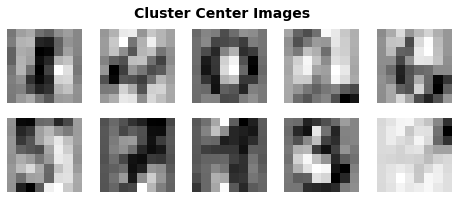

In [66]:
# Tamanho da figura em polegadas
fig = plt.figure(figsize=(8, 3))

# Adiciona o título
fig.suptitle('Cluster Center Images', fontsize=14, fontweight='bold')

# Para cada cluster (0-9)
for i in range(10):
    # Inicializa os subplots para cada posição
    ax = fig.add_subplot(2, 5, 1 + i)
    # Mostra as imagens
    ax.imshow(clf.cluster_centers_[i].reshape((8, 8)), cmap=plt.cm.binary)
    # Remove as informação de gráfico x e y
    plt.axis('off')

# Mostra a figura
plt.show()

#### Prevendo as categorias dos dígitos

Agora que temos nosso modelo ajustado podemos utilizar a função `predict` do modelo passando desde uma simples amostra a um conjunto de amostras. Como podem perceber não usamos os rótulos de treinamento (`y_train`) como _feedback_ para o modelo. Isto se deve a característica do modelo utilizado (`kmeans`) que é utilizado normalmente para aprendizado [não supervisionado]() (quando não temos a resposta para as amostras utilizadas)

In [71]:
clf.predict(X_test[0])

ValueError: ignored

Como podem a função retornou um erro. Quando tentamos passar apenas uma amostra para predição, a estrutura do dado de entrada não era esperada. Percebemos isto analisando o erro retornado, o qual além de mostrar o erro mostrou a solução para solucionalo.

In [72]:
clf.predict(X_test[0].reshape(1, -1))

array([4], dtype=int32)

Para a primeira a mostra do nosso conjunto de teste o rótulo previsto foi o número 4. Será que nosso modelo acertou a previsão?

In [74]:
y_test[0]

6

Como podemos ver o modelo treinado errou na predição. Mais adiante, vamos analisar o desempenho do modelo gerado.

In [78]:
y_pred=clf.predict(X_test)

pd.DataFrame(data=[y_pred[:100], y_test[:100]], index=["predição", "real"])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
predição,4,8,8,9,3,3,5,8,5,3,0,7,1,2,1,3,8,6,8,8,1,5,8,6,5,4,8,5,4,8,1,8,3,1,1,4,8,1,6,4,...,2,1,5,3,1,5,6,2,6,8,8,8,8,6,6,2,1,5,8,8,8,2,3,8,8,2,4,1,1,8,0,3,7,8,8,3,8,2,1,1
real,6,9,3,7,2,1,5,2,5,2,1,9,4,0,4,2,3,7,8,8,4,3,9,7,5,6,3,5,6,3,4,9,1,4,4,6,9,4,7,6,...,0,4,5,2,4,5,7,0,7,5,9,5,5,4,7,0,4,5,5,9,9,0,2,3,8,0,6,4,4,9,1,2,8,3,5,2,9,0,4,4


Visualizando as categorias inferidas

Criamos um [Isomap](https://towardsdatascience.com/decomposing-non-linearity-with-isomap-32cf1e95a483) com os dados de treinamento e teste para visualizar e comparar os dados reais com os preditos. Basicamente, o [Isomap](https://towardsdatascience.com/decomposing-non-linearity-with-isomap-32cf1e95a483), ao invés de utilizar a distância Euclidiana entre os pontos, utiliza um outro tipo de distância ao gerar o gráfico de disperção (Geodesic distance)

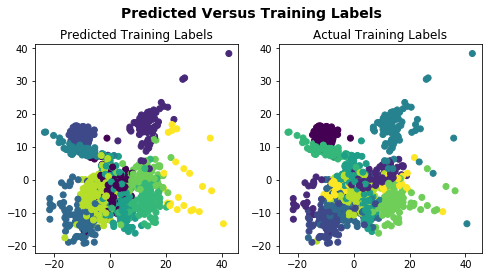

In [79]:
# Cria o Isomap e ajusta os dados de treinamento
X_iso = Isomap(n_neighbors=10).fit_transform(X_train)

# Calcula os clusters centrais
clusters = clf.fit_predict(X_train)

# Cria o subplot para os gráficos
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

# Ajusta o layout
fig.suptitle('Predicted Versus Training Labels', fontsize=14, fontweight='bold')
fig.subplots_adjust(top=0.85)

# Adiciona os gráficos de disperção
ax[0].scatter(X_iso[:, 0], X_iso[:, 1], c=clusters)
ax[0].set_title('Predicted Training Labels')
ax[1].scatter(X_iso[:, 0], X_iso[:, 1], c=y_train)
ax[1].set_title('Actual Training Labels')

# Mostra a figura
plt.show()

## Avaliando o modelo
### Métricas de clustering

Métricas para avaliação de clusters:

In [0]:
print('% 9s' % 'inertia    homo   compl  v-meas     ARI AMI  silhouette')
print('%i   %.3f   %.3f   %.3f   %.3f   %.3f    %.3f'
          %(clf.inertia_,
      metrics.homogeneity_score(y_test, y_pred),
      metrics.completeness_score(y_test, y_pred),
      metrics.v_measure_score(y_test, y_pred),
      metrics.adjusted_rand_score(y_test, y_pred),
      metrics.adjusted_mutual_info_score(y_test, y_pred),
      metrics.silhouette_score(X_test, y_pred, metric='euclidean')))

inertia    homo   compl  v-meas     ARI AMI  silhouette
54276   0.688   0.733   0.710   0.567   0.674    0.146


* A medida de homogeneidade (`homogeneity_score`) indica em que medida todos os clusters contêm apenas pontos de dados que são membros de uma única categoria.
* A medida de integralidade (`completeness_score`) mede até que ponto todos os pontos de dados que são membros de uma determinada categoria também são elementos do mesmo cluster.
* A medida V (`v_measure_score`) é a média harmônica entre homogeneidade e completude.
* A medida `adjusted_rand_score` mede a similaridade entre dois agrupamentos e considera todos os pares de amostras e pares de contagem que são atribuídos nos mesmos ou diferentes agrupamentos nos agrupamentos previstos e verdadeiros.
* A medida da Informação Mútua Ajustada (`adjusted_mutual_info_score`) é usada para comparar clusters. Ele mede a similaridade entre os pontos de dados que estão nos agrupamentos, representando agrupamentos aleatórios e assume um valor máximo de 1 quando os agrupamentos são equivalentes.
* A medida da silhueta (`silhouette_score`) mede a similaridade de um objeto ao seu próprio cluster em comparação a outros clusters. As pontuações da silhueta variam de -1 a 1, em que um valor mais alto indica que o objeto é mais compatível com seu próprio cluster e pior comparado aos clusters vizinhos. Se muitos pontos tiverem um valor alto, a configuração do clusteirng é boa.

### Matriz de confusão

É um tabela que mostra as frequências de classificação para cada classe do modelo

In [80]:
confusion_mat = metrics.confusion_matrix(y_test, y_pred)
print(confusion_mat)

[[ 0  0 43  0  0  0  0  0  0  0]
 [20  0  0  7  0  0  0 10  0  0]
 [ 5  0  0 31  0  0  0  1  1  0]
 [ 1  0  0  1  0  1  4  0 39  0]
 [ 1 50  0  0  0  0  1  2  0  1]
 [ 1  0  0  0  1 41  0  0 16  0]
 [ 0  0  1  0 44  0  0  0  0  0]
 [ 0  0  0  0  0  1 34  1  0  5]
 [21  0  0  0  0  3  1  2 11  0]
 [ 0  0  0  0  0  2  3  3 40  0]]


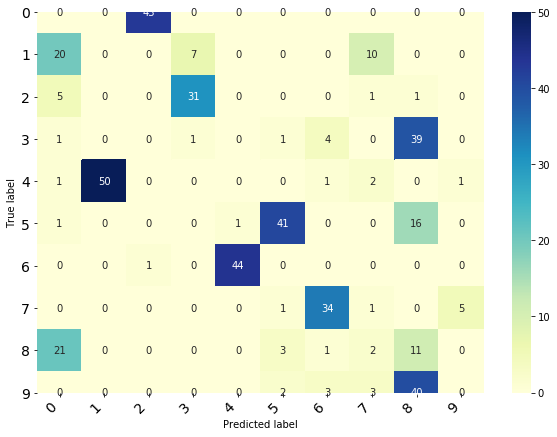

In [85]:
df_cm = pd.DataFrame(confusion_mat, index=digits.target_names, columns=digits.target_names)
fig = plt.figure(figsize=(10,7))
try:
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
except ValueError:
    raise ValueError("Confusion matrix values must be integers.")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
_ = plt.ylabel('True label')
_ = plt.xlabel('Predicted label')

### Métricas



In [104]:
print(metrics.classification_report(y_pred, y_test, digits.target_names))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        49
           1       0.00      0.00      0.00        50
           2       0.00      0.00      0.00        44
           3       0.02      0.03      0.02        39
           4       0.00      0.00      0.00        45
           5       0.69      0.85      0.77        48
           6       0.00      0.00      0.00        43
           7       0.02      0.05      0.03        19
           8       0.29      0.10      0.15       107
           9       0.00      0.00      0.00         6

    accuracy                           0.12       450
   macro avg       0.10      0.10      0.10       450
weighted avg       0.15      0.12      0.12       450



Podemos ver que com esta abordagem obtivemos uma acurácia de 12%. Será que você consegue alcançar uma acuária maior?

## SVM

Agora é com você :)

In [0]:
# Split the `digits` data into training and test sets
X_train, X_test, y_train, y_test, images_train, images_test = train_test_split(data, digits.target, digits.images, test_size=0.25, random_state=42)

# Create the SVC model 
svc_model = svm.SVC(gamma=0.001, C=100., kernel='linear')

# Fit the data to the SVC model
svc_model.fit(X_train, y_train)

SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)